# Import Data:

In [24]:
#list the data - the csv files in this directory are a result of the API code below
!ls Data

1998_housevote_meta.csv   2009_senatevote_meta.csv
1998_housevote_pos.csv	  2009_senatevote_pos.csv
1998_senatevote_meta.csv  2010_housevote_meta.csv
1998_senatevote_pos.csv   2010_housevote_pos.csv
1999_housevote_meta.csv   2010_senatevote_meta.csv
1999_housevote_pos.csv	  2010_senatevote_pos.csv
1999_senatevote_meta.csv  2011_housevote_meta.csv
1999_senatevote_pos.csv   2011_housevote_pos.csv
2000_housevote_meta.csv   2011_senatevote_meta.csv
2000_housevote_pos.csv	  2011_senatevote_pos.csv
2000_senatevote_meta.csv  2012_housevote_meta.csv
2000_senatevote_pos.csv   2012_housevote_pos.csv
2001_housevote_meta.csv   2012_senatevote_meta.csv
2001_housevote_pos.csv	  2012_senatevote_pos.csv
2001_senatevote_meta.csv  2013_housevote_meta.csv
2001_senatevote_pos.csv   2013_housevote_pos.csv
2002_housevote_meta.csv   2013_senatevote_meta.csv
2002_housevote_pos.csv	  2013_senatevote_pos.csv
2002_senatevote_meta.csv  2014_housevote_meta.csv
2002_senatevote_pos.csv   2014_housevote_pos.csv
2003_

In [25]:
!ls

Capstone Project Proposal - 2.pdf  Exploratory Data Analysis.ipynb  README.md
Data				   PROPUBLICA_API_KEY.TXT


### Get Pro Publica API working

In [26]:
import requests

#Load ProPublica API key without exposing it to github. Request one yourself. They're free.
#https://projects.propublica.org/api-docs/congress-api/
APIfile = open('./PROPUBLICA_API_KEY.TXT',)
APIkey = APIfile.read().replace('\n', '')

#simple unit tests - will throw an error if API key is malformed
assert type(APIkey) == str
assert len(APIkey) == 40

#create API key header
headers = {'X-API-Key': APIkey}

#API request function
def API_Request(end_point, verbose=True):
    '''for a given endpoint, return API response from Propublica api as a dictionary'''
    
    #send request using combined url, endpoint, and headers
    response = requests.get(url+end_point, headers=headers)
    
    #raise error if status code isn't 200. 
    response.raise_for_status()
    
    #return json response interpreted as a dictionary. 
    return response.json()

#load base url and test endpoint
url = 'https://api.propublica.org/congress/v1'
test_endpoint = '/members/new.json'

#test that the API is working. Prints 'OK' on succes
new_members = API_Request(test_endpoint)
assert new_members['status'] == 'OK'
assert new_members['results'][0]['num_results'] == '20'
print(new_members['status'])

OK


### OK, The API is working.  Let's import voting data

In [102]:
import pandas as pd
import numpy as np
from retrying import retry
from datetime import datetime
import sys


@retry(stop_max_attempt_number=5) #we're going to try this function 5 times until it returns a value
def API_attempts(endpoint):
    '''takes and endpoint and requests the API with it for a given number of times'''  
    #if we can't extract the status we'll keep trying, and if it's OK return the repsonse
    
    #initialize status as an error, this will change if we can extract it.
    status = 'Error fetching API response'
    
    #try to get the API response and extract status without throwing an error on failure
    try:
        #send endpoint to API function for request
        response = API_Request(endpoint)
        
        #extract the status of the API request
        status = response['status']   
    except:
        pass
    
    #if the status is not OK:
    if status != 'OK':
        #Say what the status is
        print(status, end=' ')
        
        #state that we're retrying
        print('retrying')
        
        raise
    else: 
        #return the response if status is ok
        return response
    
        
#let's create a function that will import vote positions for a given rollcall vote.
def import_vote(congress, chamber, session, roll_call):
    '''imports vote details and member positions of a given roll_call vote
        takes congress number 102-116 for House, 80-116 for Senate
        chamber(house|senate) session 1 for odd 2 for even-numbered years
        returns a dictionary of vote positions and API status'''
    #construct endpoint for API request
    for x in [congress, chamber, session, roll_call]:
        x = str(x)#                 
    call_endpoint = '/{}/{}/sessions/{}/votes/{}.json'.format(congress, chamber.lower(), session, roll_call)
    
    #let's attempt a few times to account for internet burps
    call_response = API_attempts(call_endpoint)
        
    #try to extract and return the vote positions
    try:
        vote = call_response['results']['votes']['vote']
        return vote
    except:
        return {}
    

def positions_df(metalist):
    '''return a dataframe of postions for a given list of vote metadata'''
    
    #initialize dataframe
    dfp = pd.DataFrame()
    
    #for every position in the list
    for congress, chamber, session, roll_call in metalist:
        
        #request the roll_call vote from the API
        vote = import_vote(congress, chamber, session, roll_call)
        
        #extract the positions from the rollcall vote data
        positions = vote.pop('positions')
        
        #turn the postions into a dataframe
        call_positions = pd.DataFrame(positions)
        
        #if both dataframes we are going to merge are not empty
        if not dfp.empty and not call_positions.empty:
            
            #handle duplicated positions for malformed returns
            dups = call_positions.duplicated()
            dups = dups.sum()
            if dups > 0: 
                call_postions = call_postions.drop_duplicates()
                print('dropped{}duplicates'.format(dups))
        
            #MERGE THE POSITIONS FOR A GIVEN ROLL CALL VOTE INTO DATAFRAME <- core of function 
            dfp = pd.merge(dfp, call_positions, on=mergelst, how='outer')
            
            #let us know it's working
            print('.', end='')
            
        #If dfp is empty this is the first run and we need to initialize it
        elif dfp.empty: 
            #make it equal to call_positions
            dfp = call_positions
            
            #make a list of the columns that will be used to merge the call positions
            mergelst = dfp.columns.tolist()[:-1]
            
            #move party and state to front of merglist
            for x in ['state','party']:
                mergelst.insert(0, mergelst.pop(mergelst.index(x)))
            
            #alert that we've started
            print('\ndf created on', congress, chamber, session, roll_call, end=' ')
        
        #handle empty postitions dataframe:
        elif call_positions.empty:
            
            #let us know there was a problem
            print('\nno vote postions available for', congress, chamber, session, roll_call, end=' ')
            
            #append a series of Nan values
            ht = dfp.shape[0]
            nans = pd.Series([np.nan for _ in range(ht)])
            print ('dfp.shape:', dfp.shape)
            print ('Appending {} NaNs'.format(len(nans)))
            dfp = pd.concat([dfp, nans], axis = 1)
            print(dfp.iloc[:3,-4:])
        
        #handle unknown issue
        else:
            print('\nunknown error for', congress, chamber, session, roll_call, end=' ')
    
    #create a multindex of partymembers
    dfp = dfp.set_index(mergelst).transpose()
    
    #after transposing use the metalist as the index
    dfp.index = metalist
    
    #return the complete data frame
    return dfp 

def import_month(year, chamber, month):
    '''import vote metadata for a given year or month and return a dataframe '''
    
    #Stop everthing if we are using a year before 1989 or after now
    assert 1989 <= year <= int(datetime.now().year), "year out of range"
    
    #construct endpoint
    call_endpoint = '/{}/votes/{}/{}.json'.format(chamber.lower(), str(year), str(month))
    
    #use endpoint to request the API robustly with attempts function
    response = API_attempts(call_endpoint)
    
    #Extract the votes from the response
    votes = response['results']['votes']

    #create a dataframe out of the votes
    votesdf = pd.DataFrame(votes)
    
    if not votesdf.empty:
        votesdf = votesdf.set_index(['congress','chamber','session','roll_call']).sort_index()
    
    #return the months dataframe
    return votesdf

def import_year(year, chamber):
    '''import votes based on dates, return a dataframe of appended votes'''
    
    
    #So we know we started:
    print('importing', chamber, year, end=' ')
    #loop through the months 
    for month in range(1,13):
        
        #import the first month
        if month == 1:
            yeardf = import_month(year, chamber, month)
       
        #import the month of votes as a df and append it to the list 
        else:
            df = import_month(year, chamber, month)
            if not df.empty:
                yeardf = yeardf.append(df)
            else:
                print('skip', end=' ')
        #print something so we know it's working
        print(month, end=' ')
        
    #return the dataframe
    return yeardf

def save_years(start_y, end_y):
    '''take a range of years and save a series of dataframes for those years in both the hosue and senate'''
    #iterate through the range of years
    for year in range(start_y, end_y+1):
        #alternate between senate and house
        for chamber in ['senate','house']:
            
            #construct paths
            metapath, pospath = construct_paths(year, chamber)
            
            #import vote metadata dataframe
            votemetadf = import_year(year, chamber)
            
            #import vote positions for given dataframe
            voteposdf = positions_df(votemetadf.index)
            
            #save them
            save_csv(year, chamber, votemetadf, metapath)
            save_csv(year, chamber, voteposdf, pospath)
            
def save_csv(year, chamber, df, path):
    '''takes dataframes from a given year and chamber and saves them to given paths'''
    #announce what we're doing
    print('\nsaving {} {} as {}'.format(str(year), chamber, path))
        
    #save data frames as csv in data/csv directory
    df.to_csv(path)
    
def construct_paths(year, chamber):
    '''construct paths to save or load csv files, 
    takes year and chamber and returns meta path and position path'''
    pathhead = 'Data/{}_{}vote_'.format(str(year), chamber)
    metapath = pathhead + 'meta.csv'
    pospath = pathhead + 'pos.csv'
    return metapath, pospath
                    
def load_cache(year, chamber):
    '''try to load data for a given year and chamber from csv, and use the API to cache it if it's missing'''
    #construct paths
    metapath, pospath = construct_paths(year, chamber.lower())
    
    #setup header / index col
    header = list(range(5))
    if chamber.lower() == 'house':
        header.append(5)
    index_col = list(range(4))
    
    #try to import to load the dfs via csv, and if they don't exist import via the API and cache them.
    try:
        votemetadf = pd.read_csv(metapath, index_col=index_col)
        
        #check if too many days have passed
        if year == int(datetime.now().year):
            assert (datetime.now() - pd.to_datetime(votemetadf.date)[-1]).days < 7, 'Cache out of date'            
    
    except (FileNotFoundError, AssertionError, KeyError) as e:
        print(e, 'importing from API')
        votemetadf = import_year(year, chamber)
        save_csv(year, chamber, votemetadf, metapath)
        
    try:
        voteposdf = pd.read_csv(pospath, header=header, index_col=index_col)
        #check indexes of postions and metadata or the same length
        assert len(voteposdf.index) == len(votemetadf.index), 'dataframe index mismatch'
    except (FileNotFoundError, AssertionError) as e:
        print(e, 'importing from API')
        voteposdf = positions_df(votemetadf.index)
        save_csv(year, chamber, voteposdf, pospath)
    
    #convert dw_nominate into float64 so it sorts correctly
    floatcol = voteposdf.columns.levels[-3].astype(float)
    newcolumns = voteposdf.columns.set_levels(floatcol, level='dw_nominate')
    voteposdf.columns = newcolumns
    
    return votemetadf, voteposdf
   
#def check_df(df)
#    '''check the df for problems and raise an exception if they are found'''
#    if int(datetime.now().year) == 
    
#testmetahouse.head()
#tests - comment out when working

#senate_month_test = import_month(2019, 'senate', 1)
#senate_month_test

#senate_2019_test = import_year(2019, 'senate')
#senate_2019_test

#positions = positions_df(senate_2019_test.index)
#positions

#save_years(2019, 2019)

#testmetasenate, test_dfsenate = load_csv(2019, 'Senate')


  

# Explore Data:

## Sort by political spectrum
Political scientists have already provided a metric for political ideology using dimension reduction called the [dw_nominate](https://voteview.com/about) In the 1st dimension, scores closer to 1 indicate conservative voting behavior while scores closer to -1 indicate liberal voting behavior. Sorting by this indicator easily distinguishes parties from one another in the multi-index of house members.

In [108]:
testmetasenate, test_dfsenate = load_cache(2019, 'Senate')
test_dfsenate.sort_index('columns', level='dw_nominate', inplace=True)
testmetasenate.date[-1]#test = test_dfsenate.columns.get_level_values('dw_nominate').tolist()
testmetasenate.head()

bill  \
congress chamber session roll_call                                                      
116      Senate  1       1          {'bill_id': 's1-116', 'number': 'S.1', 'sponso...   
                         2          {'bill_id': 's1-116', 'number': 'S.1', 'sponso...   
                         3          {'bill_id': 's1-116', 'number': 'S.1', 'sponso...   
                         4          {'bill_id': 'sjres2-116', 'number': 'S.J.RES.2...   
                         5          {'bill_id': 'sjres2-116', 'number': 'S.J.RES.2...   

                                          date  \
congress chamber session roll_call               
116      Senate  1       1          2019-01-08   
                         2          2019-01-10   
                         3          2019-01-14   
                         4          2019-01-15   
                         5          2019-01-15   

                                                                           democratic  \
congress chamber session roll_call                                                      
116      Senate  1       1          {'yes': 4, 'no': 41, 'present': 0, 'not_voting...   
                         2          {'yes': 4, 'no': 41, 'present': 0, 'not_voting...   
                         3          {'yes': 3, 'no': 40, 'present': 0, 'not_voting...   
                         4          {'yes': 0, 'no': 44, 'present': 0, 'not_voting...   
                         5          {'yes': 44, 'no': 0, 'present': 0, 'not_voting...   

                                                                          description  \
congress chamber session roll_call                                                      
116      Senate  1       1          A bill to make improvements to certain defense...   
                         2          A bill to make improvements to certain defense...   
                         3          A bill to make improvements to certain defense...   
                         4          A joint resolution disapproving the President'...   
                         5          A joint resolution disapproving the President'...   

                                    document_number  \
congress chamber session roll_call                    
116      Senate  1       1                      1.0   
                         2                      1.0   
                         3                      1.0   
                         4                      2.0   
                         5                      2.0   

                                                                       document_title  \
congress chamber session roll_call                                                      
116      Senate  1       1          A bill to make improvements to certain defense...   
                         2          A bill to make improvements to certain defense...   
                         3          A bill to make improvements to certain defense...   
                         4          A joint resolution disapproving the President&...   
                         5          A joint resolution disapproving the President&...   

                                                                          independent  \
congress chamber session roll_call                                                      
116      Senate  1       1          {'yes': 0, 'no': 2, 'present': 0, 'not_voting'...   
                         2          {'yes': 0, 'no': 2, 'present': 0, 'not_voting'...   
                         3          {'yes': 0, 'no': 2, 'present': 0, 'not_voting'...   
                         4          {'yes': 0, 'no': 2, 'present': 0, 'not_voting'...   
                         5          {'yes': 2, 'no': 0, 'present': 0, 'not_voting'...   

                                                               question  \
congress chamber session roll_call                                        
116      Senate  1       1          On Cloture on the Motion to Proceed   

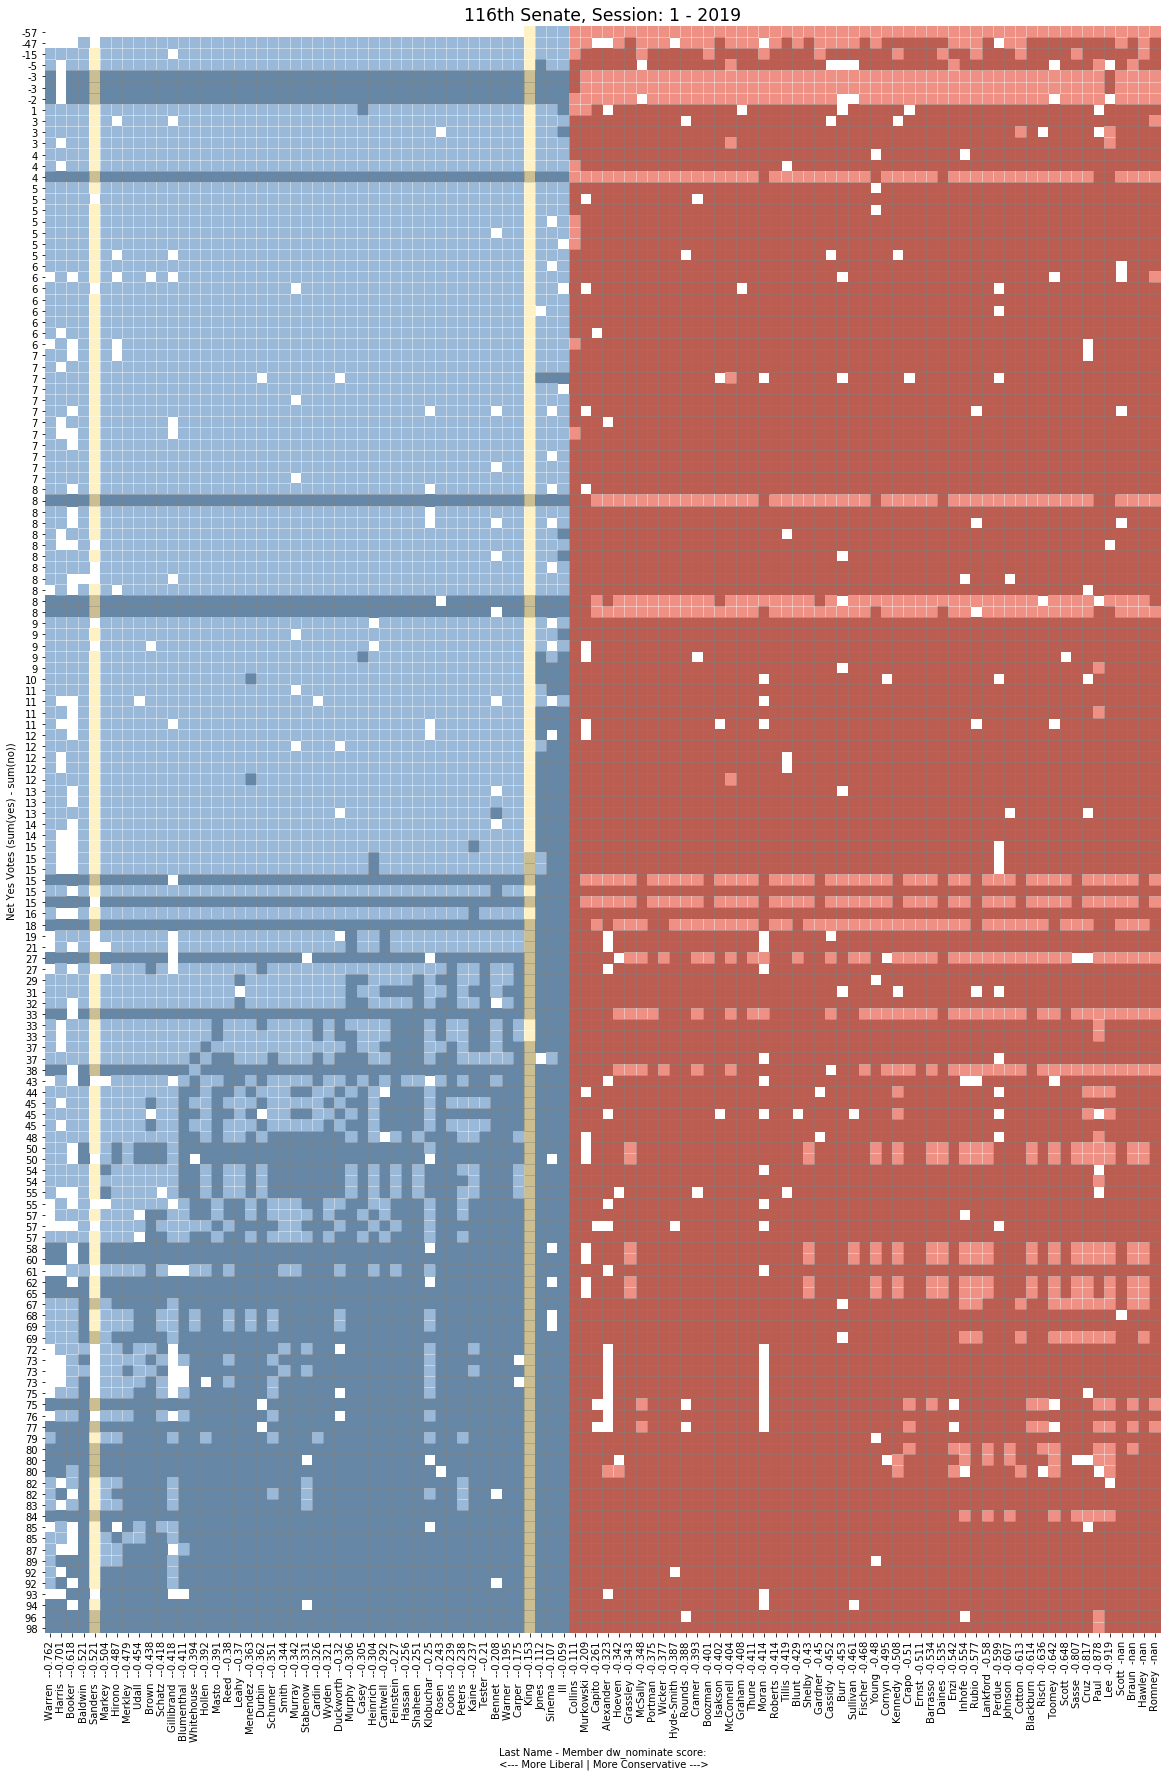

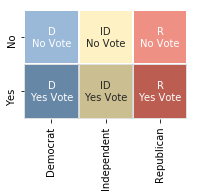

In [109]:
#plot a session
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

def visualize_session(year, chamber):
    
    #Past versions of pandas have an error that prevents multiindex sorting with floats.
    assert int(''.join(pd.__version__.split('.'))) >= 242, 'Pandas should be version 0.24.2 or above'
    
    #load dataframe from csv or API
    _, df = load_cache(year, chamber)

    #set up a default dict that will return 1 if 'Yes,' -1 if 'No,' and 0 if anything else, while adding keys.
    factordict = defaultdict(int)
    factordict['Yes'], factordict['No'] = 1,-1

    #prep data (sort by party / dw_nominate score, then code yes / no into votes into negative positive values)
    data = df.applymap(lambda x: factordict[x]).sort_index('columns', 'dw_nominate')
    
    #sort by dw_nominate. (sort_index) doesn't work with floats... so.

    
    #sort votes by net votes
    sortseries = data.sum(axis=1)
    sortseries.sort_values(inplace=True)
    data = data.reindex(sortseries.index)
    mask = data.applymap(lambda x: x == 0).values

    #create a dataframe to map red and blue colors
    partydict = defaultdict(int)
    partydict['R'], partydict['D'] = 1, -1
    colormask = data.apply(lambda x: x.index.get_level_values(0).astype(str), axis=1, result_type='expand')
    colormask = colormask.applymap(lambda x: partydict[x])
    

    #change index's to something useful
    data.index = sortseries.values
    data.index.name = 'Net Yes Votes (sum(yes) - sum(no))'
    #newcol = data.columns.droplevel([level for level in data.columns.names if not level in ['dw_nominate', 'name']])    
    dw = data.columns.get_level_values('dw_nominate')
    lastnames = data.columns.get_level_values('name').map(lambda x: x.split(" ")[-1]+'  ')
    #print(lastnames)
    data.columns = pd.MultiIndex.from_arrays([lastnames, dw], names=('Last Name ',' Member dw_nominate score:\n <--- More Liberal | More Conservative --->'))
    #data.columns.name = 
    
    #setup scale
    base=10
    scale=1
    wd = 20
    ht = int(len(data.index)/scale+base)
    #print(wd, ht)
    f, ax = plt.subplots(1,1, figsize=(wd,ht))

    sns.set_palette('muted')

    #plot the party colors
    cmap = sns.color_palette('RdYlBu_r')
    sns.heatmap(data=colormask, ax=ax, cmap=cmap, linewidth=0, alpha=1, mask=mask, cbar=False, square=True)
    #cbar=True, cbar_kws = dict(use_gridspec=False, location='bottom'))

    #plot the yes no vote data
    cmap1 = ['white','grey']
    sns.heatmap(data=data, ax=ax, cmap=cmap1, linewidth=0, cbar=False, alpha=.4, mask=mask)
    
    #set up title (will need to modify to vizualize more than one session)
    titleitems = tuple(df.index.droplevel(3).tolist()[0])
    titlestring = '{}th {}, Session: {} - {}'.format(*titleitems,year)
    ax.set_title(titlestring, fontsize='xx-large')

    #display the "legend"
    display_key(cmap, cmap1)
    
    #display the p
    plt.show()

def display_key(cmap, cmap1):
    #Create the key
    f, ax1 = plt.subplots(1, figsize=(3, 2))

    labels = np.array([['D\nNo Vote','ID\nNo Vote','R\nNo Vote'],\
                   ['D\nYes Vote','ID\nYes Vote','R\nYes Vote']])

    xticklabels=['Democrat','Independent','Republican']
    yticklabels=['No','Yes']

    sns.heatmap(data=[[-1,0,1],[-1,0,1]], ax=ax1, cmap=cmap, linewidth=1, cbar=False, alpha=1, annot=labels, fmt='', square=True)
    sns.heatmap(data=[[-1,-1,-1],[1,1,1]], ax=ax1, cmap=cmap1, linewidth=1, cbar=False, alpha=.4, xticklabels=xticklabels, yticklabels=yticklabels)

    #show the plot

visualize_session(2019, 'Senate')


The plot above can be used to visualize all the votes in a given session, sorted by how many net votes they received, and the, and how liberal/conservative members are according to their dw_nominate score. 

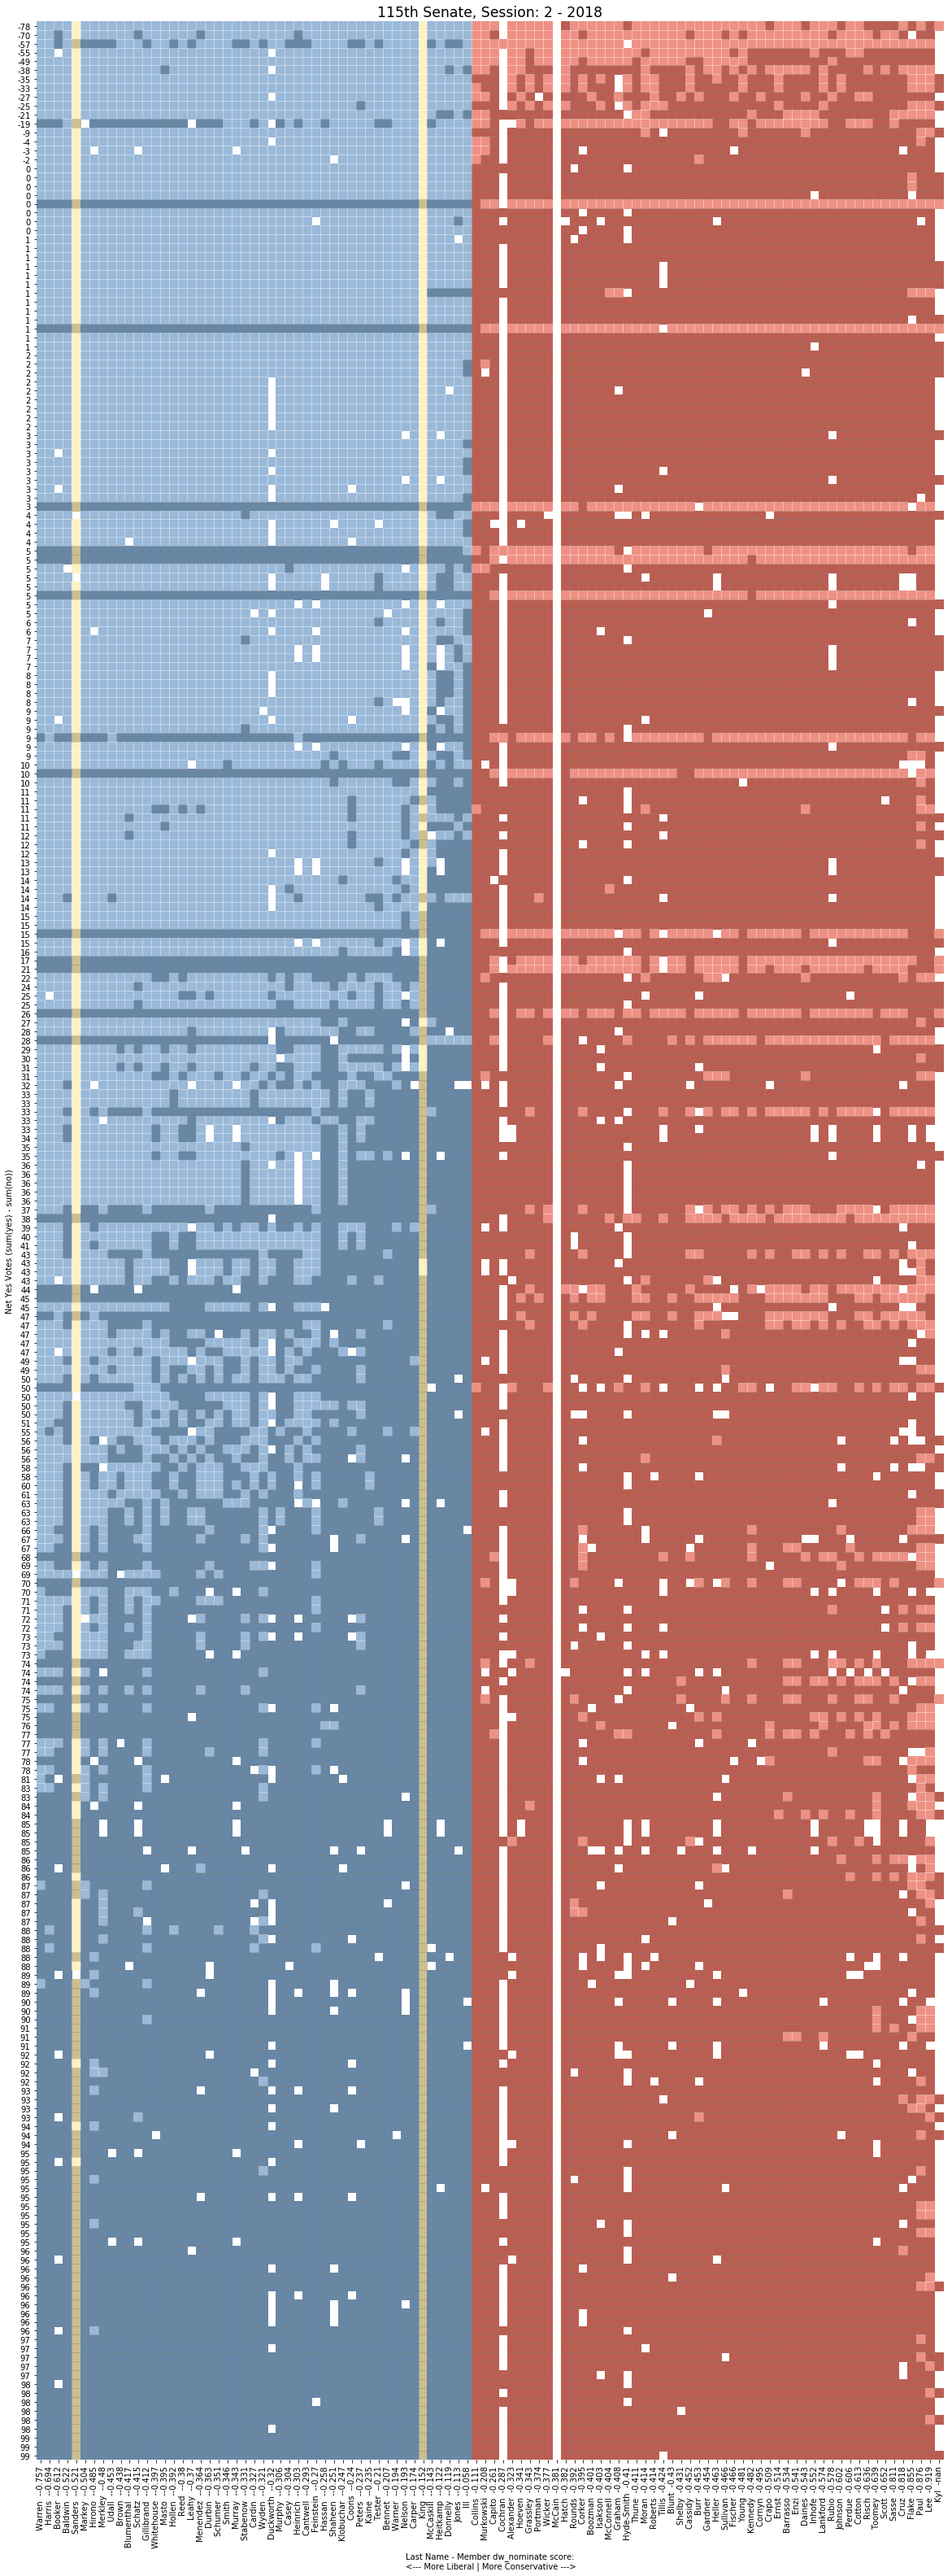

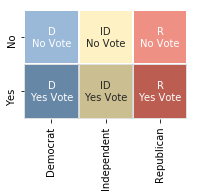

In [111]:
visualize_session(2018, 'Senate')

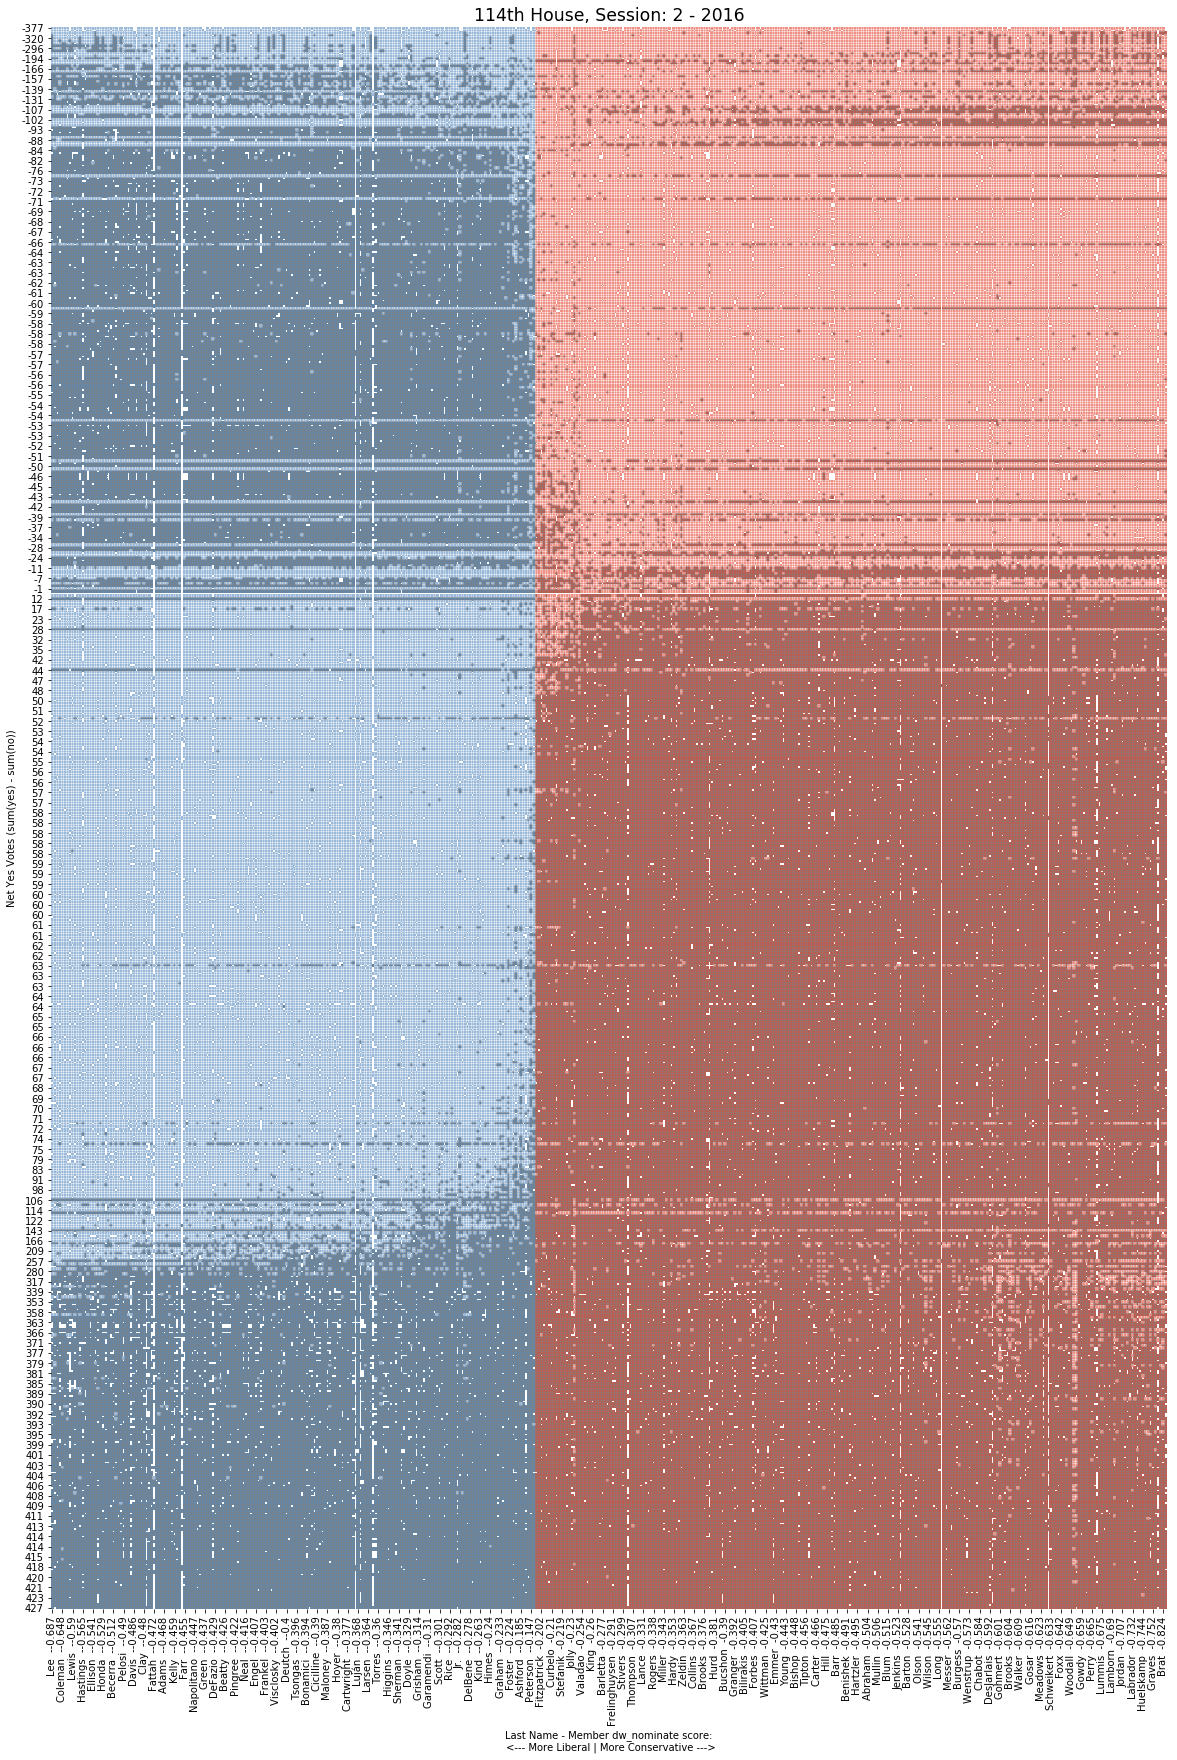

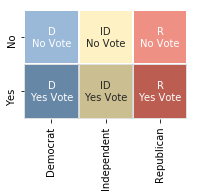

In [112]:
visualize_session(2016, 'house')

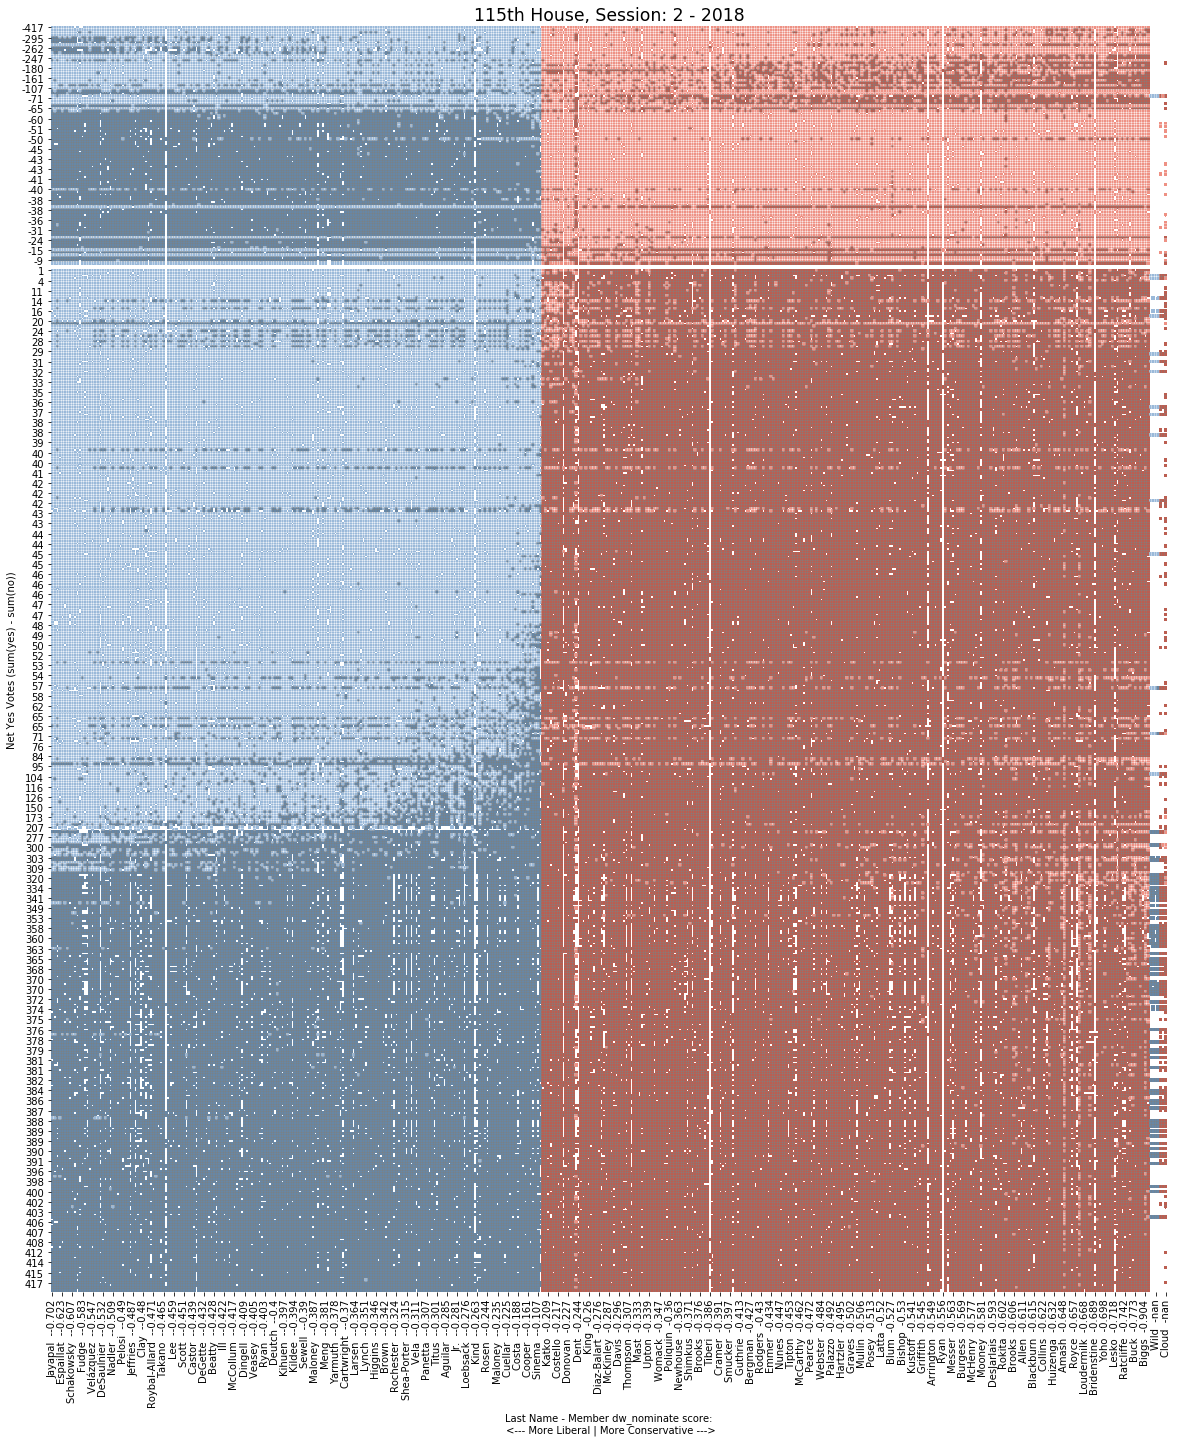

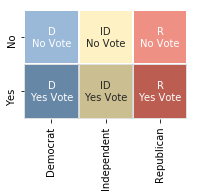

In [113]:
visualize_session(2018, 'House')

dataframe index mismatch importing from API

df created on 116 House 1 1 ................................................................................................................................................................................................................................................
saving 2019 house as Data/2019_housevote_pos.csv


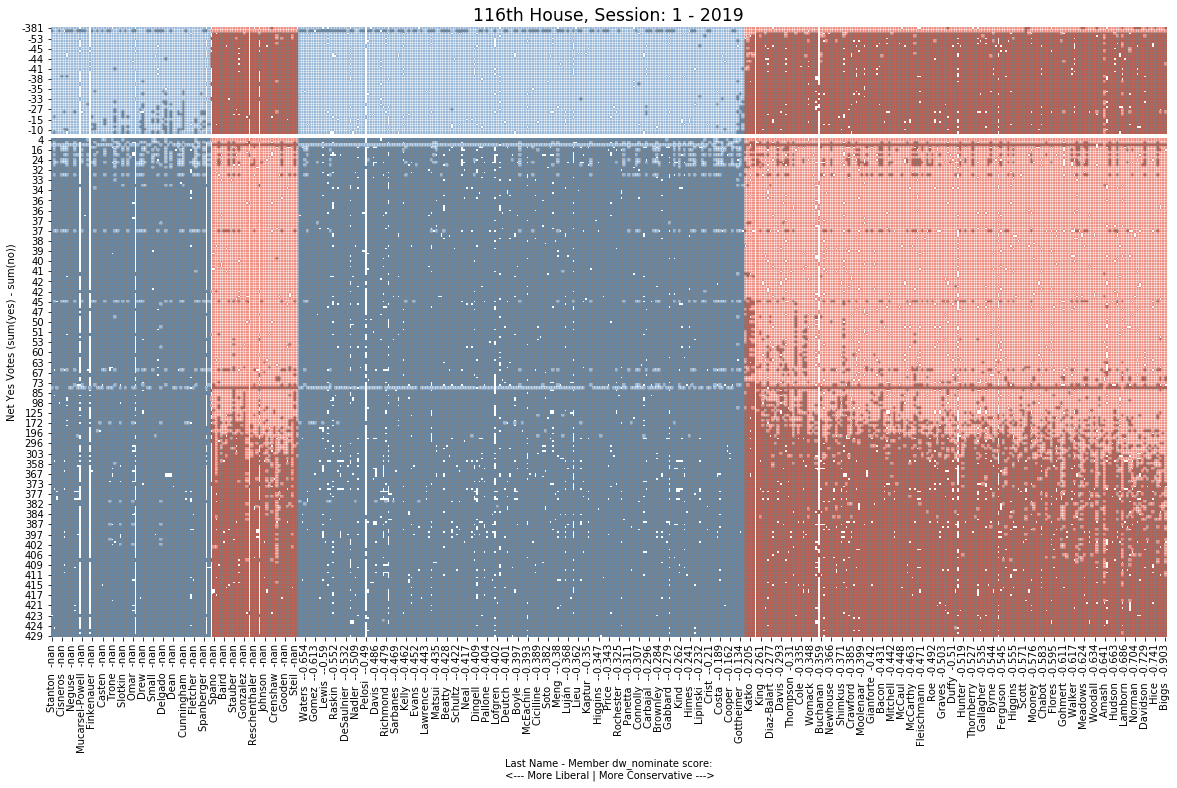

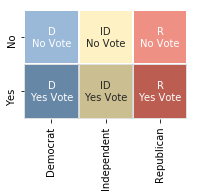

In [114]:
visualize_session(2019, 'house')